    AUTHOR : Mikael Frenette
    
    IN THIS TUTORIAL, I WILL INTRODUCE THE BASIC USAGE OF THE MODEL PROPOSED
    IN THE PAPER "From Reactive to Proactive Volatility Modeling with
    Hemisphere Neural Networks" by Philippe Goulet Coulombe, Mikael Frenette
    and Karin Klieber (2023).

    TO SEE IMPLEMENTATION SOURCE CODE, PLEASE SEE THE GITHUB :
    https://github.com/TheAionxGit/Aionx

    FOR ANY QUESTION PLEASE COMMUNICATE WITH ME:
     - Mikael Frenette (mik.frenette@gmail.com)
                                 
                                  IMPORTANT
    ***************************************************************************

    PLEASE NOTE THAT THIS IMPLEMENTATION IS SUBJECTED TO LIMITED FLEXIBILITY
    AND MAY NOT SCALE AS INTENDED. A SECOND TUTORIAL WILL BE
    AVAILABLE ON THE GITHUB AND WILL LET USERS EXPERIMENT WITH THE 'BASE'
    FUNCTIONS USED TO DEVELOP THE MODEL.

    THE 'DensityHNN' CLASS IS DESIGNED FOR SMALL DATASETS SUCH AS FRED-MD OR
    FRED-QD. DO NOT USE THIS CLASS WITH DATA SUBJECTED TO IRREGULAR TIMESTAMPS
    SUCH AS STOCK MARKET DATA (WHICH HAVE HOLIDAYS), BECAUSE PANDAS CANNOT
    INFER FROM THEIR TIMESTAMP EASILY. ADDITIONALY, I WOULD RECOMMEND NOT USING
    THE CLASS ON LARGE DATASET SINCE THIS IMPLEMENTATION DOES NOT SUPPORT A
    MINIBATCH LEARNING AND LARGE BATCHES MAY QUICKLY LEAD TO MEMORY ERROR.

    FINALLY, THE 'DensityHNN' BASE CODE IS STILL IN DEVELOPMENT AND MORE
    FUNCTIONALITIES WILL BE ADDED IN THE FUTURE.
    
    ***************************************************************************

In [1]:
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.data.experimental.enable_debug_mode()
gpus = tf.config.list_physical_devices(device_type = 'GPU')
if gpus:
    print(gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True) # let tensorflow control GPU memory usage
else:
    print("No GPU detected.")
    
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from arch import arch_model
from arch.__future__ import reindexing
from sklearn.linear_model import LinearRegression

from aionx.models import DensityHNN
from aionx.metrics import RootMeanSquaredError, NominalCoverage, LogScore
from aionx.pipelines import RegressionMatrix

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# **NOTE : 
# - DensityHNN class is designed in a way that it can be run in graph mode.
# - For more information about properties of graph mode, please read tensorflow's documentations:
# - https://www.tensorflow.org/guide/intro_to_graphs

# - by default graph mode is enabled. This will significantly increase the training speed of 
#   neural networks.

# - If one wishes to run the model in eager mode or if the function is causing
#   operation issues, graph mode can be disabled by setting : 

#   tf.config.run_functions_eagerly(True)

tf.config.run_functions_eagerly(False)

# FORECASTING SETUP
<br>

- We fit the model from 1961-09-01 until 2006-12-01. The pseudo out-of-sample will be from 2007-01-01 until 2022-12-01. 
<br><br>
- On the FRED-QD data, we use 2 lags. For FRED-MD, we use 6 lags.
<br><br>
- For this example, we will try to predict the US GDP one step in the future (s=1).

<br><br>
####  A LITTLE WORD ON THE DATASET
<br>
One must use a dataset which index is a DatetimeIndex. Maybe these lines of code can help:
 <br><br>
data.set_index('your_date_column_name', inplace=True)
<br>
data.index = pd.to_datetime(data.index)

In [3]:
# Import data
data = pd.read_csv("FREDQD.csv")
data.set_index("date", inplace=True)
data.index = pd.to_datetime(data.index)

TRAIN_START = "1961-01-01"
TRAIN_END   = "2006-12-01"
TEST_START  = "2007-01-01"
TEST_END    = "2022-12-01"

LAGS = 2
H = 1
TARGET = "GDPC1"

In [4]:
# initialize metrics. These metrics are all callable.
RMSE       = RootMeanSquaredError()
Score      = LogScore()
Coverage68 = NominalCoverage(std=1)
Coverage95 = NominalCoverage(std=2)

# The objective
<br><br>

we aim to minimize the following equation using a neural network architecture which contains 2 seperate hemispheres: $h_{m}$ and $h_{v}$.

<br>

$$\min_{\theta_{m}, \theta_{v}}  \sum_{t=1}^T  \frac{\left( y_{t+1} - h_m (\boldsymbol{X}_t;\theta_m)\right)^2 }{h_v(\boldsymbol{X}_t;\theta_v)}  + \log(h_v(\boldsymbol{X}_t;\theta_v))$$

where:
- $h_{m}$ is the conditional mean hemisphere and $h_{v}$ the conditional volatility hemisphere.
- $\theta_m$ and $\theta_{v}$ are $h_{m}$ and $h_{v}$ weights respectively.
- $\boldsymbol{X}_t$ is a set of covariate which, in this example, will be fred-qd data. 

Since the conditional volatility is prone to vanishing when the network is entering overfitting territory, we estimate an ensemble of regular fully connected neural networks prior to the HNN. We compute its out-of-bag's mean squared error and use the value as volatility emphasis parameter $\nu$. This parameter will help the HNN's training by mitigating the importance of uncertainty estimates.
<br><br>
Since the HNN is also an ensemble of networks, we compute its conditional mean and conditional volatility as follow:
$${h}_j(\boldsymbol{X}_t;\hat{\theta}_{j}) = \frac{1}{(1-\tau) \times B} \sum_{b=1}^B I({h}_j(\boldsymbol{X}_t;\hat{\theta}_{j,b})\neq  \texttt{NA}){h}_j(\boldsymbol{X}_t;\hat{\theta}_{j,b})  \quad \text{for } j \in \{m, v \}.$$

where:
- $\tau$ is the sampling rate parameter
- B is the number of bootstraps.

In [5]:
HNN = DensityHNN(
     target  = TARGET,        # the target.
     lags    = LAGS,          # Number of lags. (2 for QD 6 for MD)
     horizon = H,             # steps in the futur to forecast. (1 and 4 for QD)
     bootstraps = 200,         # number of bootstrap for the HNN. (1000 in the paper)
     prior_bootstraps = 200,   # number of bootstrap for the prior DNN. (1000 in the paper)
     trends = 100,            # number of trends to use. (100 in the paper)
     sampling_rate = 0.8,     # % of samples in each bootstrap. (0.8 in the paper)
     block_size = 8,          # the size of blocks to bootstrap. (8 for QD 24 for MD)
     epochs = 100,            # number maximal of epoch.
     learning_rate = 1e-3,    # the learning rate parameter for the Adam optimizer. (1e-3 in the paper)
     patience = 15,           # the patience parameter for early stopping. (15 in the paper)
     verbose = 2              # the level of verbosity. (0=None, 1=print model, 2=print network).
)

results = HNN.run(
    data = data,             
    train_start = TRAIN_START,
    train_end = TRAIN_END,
    expanding = False,
    expanding_start = "2007-01-01",
    expanding_steps = 8,
    last_expanding_window = dt.datetime(2019, 12, 1)
)

HNN_preds = results["hnn_forecast"]
prior_dnn_preds = ["dnn_forecast"]
vol_emphasis = results["volatility_emphasis"]

print(f"\n volatility emphasis computed for {TARGET} : {vol_emphasis}")

#---------------------------------
# ONLY WORKS IF expanding = False
#---------------------------------
#conditional_mean_bootstraps = results["hnn_bootstraps"]["conditional_mean"]
#conditional_vol_bootstraps = results["hnn_bootstraps"]["conditional_vol"]

prior_dnn [1/200] |█████████-----------| Step: 1/1 | Epoch: 44/100 (44%) | loss: 0.0804 | val_loss: 1.1124 
prior_dnn [2/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: 0.1699 | val_loss: 1.2298 
prior_dnn [3/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: 0.2302 | val_loss: 0.6072 
prior_dnn [4/200] |████----------------| Step: 1/1 | Epoch: 17/100 (17%) | loss: 0.2189 | val_loss: 0.4839 
prior_dnn [5/200] |████----------------| Step: 1/1 | Epoch: 19/100 (19%) | loss: 0.1934 | val_loss: 0.7634 
prior_dnn [6/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: 0.2343 | val_loss: 0.7205 
prior_dnn [7/200] |█████████-----------| Step: 1/1 | Epoch: 43/100 (43%) | loss: 0.0723 | val_loss: 0.8760 
prior_dnn [8/200] |████----------------| Step: 1/1 | Epoch: 18/100 (18%) | loss: 0.1959 | val_loss: 0.4281 
prior_dnn [9/200] |████----------------| Step: 1/1 | Epoch: 16/100 (16%) | loss: 0.3467 | val_loss: 1.0006 
prior_dnn [10/200] |███████-

prior_dnn [76/200] |█████---------------| Step: 1/1 | Epoch: 21/100 (21%) | loss: 0.1662 | val_loss: 0.9163 
prior_dnn [77/200] |████████████--------| Step: 1/1 | Epoch: 57/100 (57%) | loss: 0.0725 | val_loss: 0.4428 
prior_dnn [78/200] |█████---------------| Step: 1/1 | Epoch: 22/100 (22%) | loss: 0.1779 | val_loss: 0.9007 
prior_dnn [79/200] |█████---------------| Step: 1/1 | Epoch: 22/100 (22%) | loss: 0.2381 | val_loss: 0.9152 
prior_dnn [80/200] |█████---------------| Step: 1/1 | Epoch: 21/100 (21%) | loss: 0.2076 | val_loss: 0.9827 
prior_dnn [81/200] |████----------------| Step: 1/1 | Epoch: 16/100 (16%) | loss: 0.2395 | val_loss: 0.7372 
prior_dnn [82/200] |████----------------| Step: 1/1 | Epoch: 18/100 (18%) | loss: 0.1520 | val_loss: 0.9833 
prior_dnn [83/200] |█████---------------| Step: 1/1 | Epoch: 22/100 (22%) | loss: 0.1238 | val_loss: 0.8576 
prior_dnn [84/200] |█████---------------| Step: 1/1 | Epoch: 21/100 (21%) | loss: 0.2471 | val_loss: 0.7306 
prior_dnn [85/200] 

prior_dnn [150/200] |████----------------| Step: 1/1 | Epoch: 18/100 (18%) | loss: 0.2220 | val_loss: 0.8001 
prior_dnn [151/200] |████----------------| Step: 1/1 | Epoch: 19/100 (19%) | loss: 0.3326 | val_loss: 0.5512 
prior_dnn [152/200] |████----------------| Step: 1/1 | Epoch: 17/100 (17%) | loss: 0.2157 | val_loss: 0.9859 
prior_dnn [153/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: 0.2101 | val_loss: 0.6679 
prior_dnn [154/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: 0.1451 | val_loss: 0.8362 
prior_dnn [155/200] |████----------------| Step: 1/1 | Epoch: 17/100 (17%) | loss: 0.4095 | val_loss: 0.4941 
prior_dnn [156/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: 0.2210 | val_loss: 0.9917 
prior_dnn [157/200] |████████████--------| Step: 1/1 | Epoch: 60/100 (60%) | loss: 0.0644 | val_loss: 0.5127 
prior_dnn [158/200] |███████████---------| Step: 1/1 | Epoch: 52/100 (52%) | loss: 0.0563 | val_loss: 1.2226 
prior_dnn 

density_hnn [23/200] |█████---------------| Step: 1/1 | Epoch: 23/100 (23%) | loss: 0.0720 | val_loss: 1.20214 
density_hnn [24/200] |█████---------------| Step: 1/1 | Epoch: 25/100 (25%) | loss: -0.3616 | val_loss: 0.5345 
density_hnn [25/200] |██████--------------| Step: 1/1 | Epoch: 28/100 (28%) | loss: -1.1301 | val_loss: 2.3041 
density_hnn [26/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: -0.5159 | val_loss: 0.9744 
density_hnn [27/200] |█████████-----------| Step: 1/1 | Epoch: 41/100 (41%) | loss: -1.2317 | val_loss: 7.9265 
density_hnn [28/200] |██████--------------| Step: 1/1 | Epoch: 29/100 (29%) | loss: -0.3128 | val_loss: 1.1183 
density_hnn [29/200] |██████--------------| Step: 1/1 | Epoch: 28/100 (28%) | loss: -0.6128 | val_loss: 0.4595 
density_hnn [30/200] |██████--------------| Step: 1/1 | Epoch: 27/100 (27%) | loss: -0.0744 | val_loss: 0.9587 
density_hnn [31/200] |████----------------| Step: 1/1 | Epoch: 18/100 (18%) | loss: -0.4533 | val_loss: 

density_hnn [96/200] |█████---------------| Step: 1/1 | Epoch: 23/100 (23%) | loss: -0.6083 | val_loss: 0.4792 
density_hnn [97/200] |███████-------------| Step: 1/1 | Epoch: 32/100 (32%) | loss: -0.9113 | val_loss: 6.7788 
density_hnn [98/200] |████----------------| Step: 1/1 | Epoch: 19/100 (19%) | loss: -0.5549 | val_loss: 6.6570 
density_hnn [99/200] |█████---------------| Step: 1/1 | Epoch: 21/100 (21%) | loss: -0.6660 | val_loss: 3.2947 
density_hnn [100/200] |█████---------------| Step: 1/1 | Epoch: 23/100 (23%) | loss: 2.4679 | val_loss: 2.83405 
density_hnn [101/200] |██████--------------| Step: 1/1 | Epoch: 27/100 (27%) | loss: -0.6183 | val_loss: 3.9179 
density_hnn [102/200] |█████---------------| Step: 1/1 | Epoch: 25/100 (25%) | loss: -0.3230 | val_loss: 2.2294 
density_hnn [103/200] |██████--------------| Step: 1/1 | Epoch: 26/100 (26%) | loss: -0.6152 | val_loss: 6.9647 
density_hnn [104/200] |████████------------| Step: 1/1 | Epoch: 39/100 (39%) | loss: -0.6339 | val_l

density_hnn [168/200] |█████---------------| Step: 1/1 | Epoch: 25/100 (25%) | loss: -0.8172 | val_loss: 2.0751 
density_hnn [169/200] |████----------------| Step: 1/1 | Epoch: 20/100 (20%) | loss: -0.5021 | val_loss: 2.5740 
density_hnn [170/200] |█████---------------| Step: 1/1 | Epoch: 25/100 (25%) | loss: -0.5379 | val_loss: 1.4113 
density_hnn [171/200] |█████---------------| Step: 1/1 | Epoch: 21/100 (21%) | loss: -0.2454 | val_loss: 2.4317 
density_hnn [172/200] |█████---------------| Step: 1/1 | Epoch: 23/100 (23%) | loss: -0.0708 | val_loss: 0.5188 
density_hnn [173/200] |██████--------------| Step: 1/1 | Epoch: 27/100 (27%) | loss: 0.9952 | val_loss: 5.26753 
density_hnn [174/200] |█████---------------| Step: 1/1 | Epoch: 23/100 (23%) | loss: 0.0115 | val_loss: 0.5386 
density_hnn [175/200] |██████--------------| Step: 1/1 | Epoch: 28/100 (28%) | loss: -0.8903 | val_loss: 13.2664 
density_hnn [176/200] |█████---------------| Step: 1/1 | Epoch: 22/100 (22%) | loss: -0.7840 | v

# BENCHMARKS
<br>
We use an AR(p) model as benchmark for the Root mean squared error metric.

$$ Y_{t} = \alpha + \sum\limits_{p=1}^{P} \phi_{p} Y_{t-p} + \epsilon_{t} $$

where:
- $y_t$ is the dependent variable at time $t$,
- $\alpha$ and $\phi$ are coefficients to estimate
- $Y_{t-1}$, $Y_{t-2}$, $\ldots$, $Y_{t-P}$ are the lagged values of the dependent variable,
- $ \epsilon_t $ is the error term.


<br>
We use a Garch(p, q) model as benchmark for comparing density metrics. Please note that we use a Garch model in this tutorial for simplicity. We estimate the Garch by maximizing its log likelikehood.

$$ \ln L = -\frac{T}{2}\ln(2\pi) - \frac{1}{2}\sum\limits_{t=1}^{T}\ln(\sigma^{2}_{t}) - \frac{1}{2} \sum\limits_{t=1}^{T}\frac{ \epsilon^{2}_{t} }{ \sigma_{t}^{2} } $$

where:
- $\ln L$ is the estimated log likelihood.
- $\sigma$ is the conditional volatility process.
- $\epsilon$ are the residuals coming from the conditional mean process.

In [11]:

# will store metrics here
bench_results = pd.DataFrame()

matrix_generator = RegressionMatrix(targets=[TARGET], in_steps=LAGS, horizon=H)
matrix = matrix_generator(data[[TARGET]], return_dataframe=True).dropna()

# set training inputs
X_train = matrix.loc[TRAIN_START:TRAIN_END, :].drop(TARGET, axis=1)
y_train = matrix.loc[TRAIN_START:TRAIN_END, TARGET]

# create linear regression model
model = LinearRegression()
model.fit(X_train, y_train) # fit the model

# create forecasted indexes
fcst_index = pd.date_range(matrix.index[0],
                           periods=len(matrix),
                           freq=pd.infer_freq(data.index))

AR = pd.DataFrame(
    model.predict(matrix.iloc[:, 1:]), columns=[TARGET], index=fcst_index
)

# align and remove N/A values
merged = pd.concat([matrix[TARGET], AR[TARGET]], axis=1)

# I compute now some necessary metrics from the benchmarks
# by setting squared to false, we get the RMSE.
AR2_train_mse = RMSE(
    merged.loc[TRAIN_START:TRAIN_END].iloc[:, 0],
    merged.loc[TRAIN_START:TRAIN_END].iloc[:, 1]
)
AR2_test1_mse = RMSE(
    merged.loc[TEST_START:"2020-01-01"].iloc[:, 0],
    merged.loc[TEST_START:"2020-01-01"].iloc[:, 1]
)
AR2_test2_mse = RMSE(
    merged.loc[TEST_START:TEST_END].iloc[:, 0],
    merged.loc[TEST_START:TEST_END].iloc[:, 1]
)

# store metrics in a dataframe
bench_results.loc["train set", f"{TARGET}_h{1}"]  = AR2_train_mse
bench_results.loc["val set", f"{TARGET}_h{1}"]  = AR2_test1_mse
bench_results.loc["test set", f"{TARGET}_h{1}"] = AR2_test2_mse

# fit a garch model
garch = arch_model(y=data[TARGET], mean="AR", p=1, q=1, vol = 'GARCH', lags=LAGS,
                            dist = 'normal').fit(disp=False, last_obs=TRAIN_END,
                                                 options={"maxiter":10000,
                                                                "ftol":1e-5,
                                                                "eps":1e-4})

# produce forecast with the garch model
fc = garch.forecast(horizon=1, start = data.index[0+LAGS], align="target")

# keep and transform what is needed.
AR_Garch = pd.DataFrame({
  "mean":fc.mean.iloc[:, -1].squeeze(),
  "volatility":np.sqrt(fc.variance.iloc[:, -1].squeeze())
}, index=fc.mean.index).dropna()


C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.067e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


C:\Users\User\AppData\Local\Temp\ipykernel_24112\1628426028.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  legend = fig.legend([target_ax, mean_ax, garch_ax],


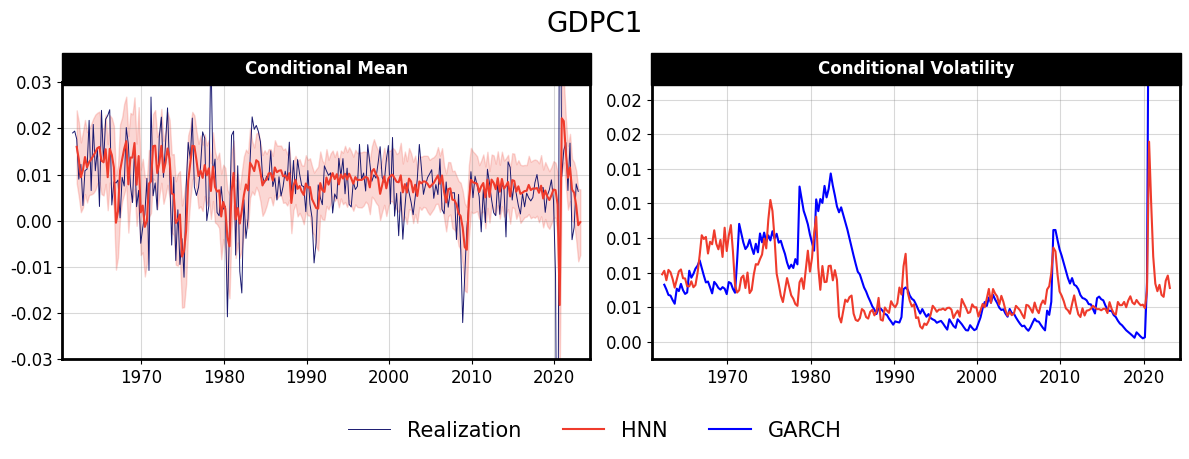

In [12]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2.0

# plot size
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols =2, figsize=(12, 4))
fig.suptitle(f"{TARGET}", size=20)

target_ax = ax0.plot(data[TARGET], color="midnightblue", linewidth=.7)[0]
mean_ax   = ax0.plot(HNN_preds[f"conditional_mean"], color="#ef3b2c")[0]
garch_ax  = ax1.plot(AR_Garch["volatility"], color="blue")[0]
vol_ax  = ax1.plot(HNN_preds[f"conditional_vol"], color="#ef3b2c")


legend = fig.legend([target_ax, mean_ax, garch_ax],
           labels=[f"Realization", "HNN", "GARCH"],
            loc='upper center', bbox_to_anchor=(0.5, -0.00),
                  fancybox=False, shadow=False, ncol=5, frameon=False,
                  fontsize=10,  prop={"size":15})

ax0.fill_between(HNN_preds.index,
                     HNN_preds[f"conditional_mean"].squeeze()- HNN_preds[f"conditional_vol"].squeeze(), # lower bound
                     HNN_preds[f"conditional_mean"].squeeze() + HNN_preds[f"conditional_vol"].squeeze(), # upper bound
                     color="#ef3b2c", alpha=.2)

title1 = ax0.set_title("Conditional Mean",  backgroundcolor='black', color='white',
                      fontweight="bold",
                size=12, position=(.5, 1.01))
title1._bbox_patch._mutation_aspect = 0.04
title1.get_bbox_patch().set_boxstyle("square", pad=11)

ax0.tick_params(axis="both", labelsize=12)
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax0.grid(color='grey', alpha=.3)
ax0.margins(x=0.02)
ax0.margins(y=0.02)

if TARGET == "GDPC1":
    ax0.set_ylim((-0.03, 0.03))
    ax1.set_ylim((0.003, .019))

title1 = ax1.set_title("Conditional Volatility",  backgroundcolor='black', color='white',
                      fontweight="bold",
                size=12, position=(.5, 1.01))
title1._bbox_patch._mutation_aspect = 0.04
title1.get_bbox_patch().set_boxstyle("square", pad=10)

ax1.tick_params(axis="both", labelsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.grid(color='grey', alpha=.3)
ax1.margins(x=0.02)
ax1.margins(y=0.02)

plt.tight_layout()  
plt.show()

### Evaluation metrics used in this tutorial are the following :<br><br>

the root mean squared error (RMSE):
$$RMSE_{s} = \sqrt{ \frac{1}{T}\sum_{t=1}^{T} (y_{t+s}-\hat{y}_{t+s})^2}$$
<br><br>
the log score ($L_{s}$):
$$L_{s} = - \frac{1}{T}\sum_{T}^{T} \log \left( \varphi (\varepsilon_{t,s}; \hat{\sigma}_{t,s})\right) $$
<br><br>
and finally, the nominal coverage which computes the proportion of errors smaller than volatility:

$$cov_{68} = \frac{\sum\limits_{t \in oos}(\epsilon_{t} < \sigma_{t})}{\# oos}$$
<br>
$$cov_{95} = \frac{\sum\limits_{t \in oos}(\epsilon_{t} < 2*\sigma_{t})}{\# oos}$$

In [8]:
metrics = pd.DataFrame()
model_dict = {"HNN":HNN_preds, "GARCH":AR_Garch}
# calcule des rmses qu'on divise par l'indice de référence (les AR(2))
for model, fcst in model_dict.items():
    merged = pd.concat([
        data[TARGET],
        fcst
    ], axis=1).dropna()

    merged.columns = [TARGET, "mean", "vol"]

    train_RMSE = RMSE(
        merged.iloc[:, 0].loc[TRAIN_START:TRAIN_END],
        merged.iloc[:, 1].loc[TRAIN_START:TRAIN_END]
    ) / AR2_train_mse

    test1_RMSE = RMSE(
        merged.iloc[:, 0].loc[TEST_START:"2020-01-01"],
        merged.iloc[:, 1].loc[TEST_START:"2020-01-01"]
    ) / AR2_test1_mse

    test2_RMSE = RMSE(
        merged.iloc[:, 0].loc[TEST_START:TEST_END],
        merged.iloc[:, 1].loc[TEST_START:TEST_END]
    ) / AR2_test2_mse

    train_score = Score(
        merged.loc[TRAIN_START:TRAIN_END, [TARGET]],
        merged.loc[TRAIN_START:TRAIN_END, ["mean", "vol"]]
    )

    test1_score = Score(
        merged.loc[TEST_START:"2020-01-01", TARGET],
        merged.loc[TEST_START:"2020-01-01", ["mean", "vol"]]
    )

    test2_score = Score(
        merged.loc[TEST_START:TEST_END, TARGET],
        merged.loc[TEST_START:TEST_END, ["mean", "vol"]]
    )

    train_cov68 = Coverage68(
        y_true=merged.loc[TRAIN_START:TRAIN_END, TARGET],
        y_pred=merged.loc[TRAIN_START:TRAIN_END, ["mean", "vol"]]
    )

    test1_cov68 = Coverage68(
        y_true=merged.loc[TEST_START:"2020-01-01", TARGET],
        y_pred=merged.loc[TEST_START:"2020-01-01", ["mean", "vol"]]
    )

    test2_cov68 = Coverage68(
        y_true=merged.loc[TEST_START:TEST_END, TARGET],
        y_pred=merged.loc[TEST_START:TEST_END, ["mean", "vol"]]
    )


    train_cov95 = Coverage95(
        y_true=merged.loc[TRAIN_START:TRAIN_END, TARGET],
        y_pred=merged.loc[TRAIN_START:TRAIN_END, ["mean", "vol"]]
    )

    test1_cov95 = Coverage95(
        y_true=merged.loc[TEST_START:"2020-01-01", TARGET],
        y_pred=merged.loc[TEST_START:"2020-01-01", ["mean", "vol"]]
    )

    test2_cov95 = Coverage95(
        y_true=merged.loc[TEST_START:TEST_END, TARGET],
        y_pred=merged.loc[TEST_START:TEST_END, ["mean", "vol"]]
    )


    metrics.loc["RMSE(oob)", model] = train_RMSE
    metrics.loc["RMSE < 2020", model]   = test1_RMSE
    metrics.loc["RMSE", model]  = test2_RMSE
    metrics.loc["Score(oob)", model] = train_score
    metrics.loc["Score < 2020", model]   = test1_score
    metrics.loc["Score", model]  = test2_score

    metrics.loc["coverage 68% oob", model] = train_cov68
    metrics.loc["coverage 68% < 2020", model] = test1_cov68
    metrics.loc["coverage 68% Test set", model] = test2_cov68
    metrics.loc["coverage 95% oob", model] = train_cov95
    metrics.loc["coverage 95% < 2020", model] = test1_cov95
    metrics.loc["coverage 95% Test set", model] = test2_cov95

metrics


,HNN,GARCH
RMSE(oob),0.894669,1.001831
RMSE < 2020,0.819989,1.007367
RMSE,0.994509,1.001421
Score(oob),-3.554992,-3.521348
Score < 2020,-3.888557,-3.716261
Score,-2.098492,-2.114522
coverage 68% oob,0.677778,0.709497
coverage 68% < 2020,0.865385,0.846154
coverage 68% Test set,0.796875,0.828125
coverage 95% oob,0.977778,0.966480
